<a href="https://colab.research.google.com/github/yrodriguezmd/Surgical_instruments/blob/main/Sets/Set_S/subsets/Set_1_7/notebooks/Set_1_7_Model_G_ret_epoch100_oct20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use Set_1_7 merged dataset, annotated, split in train/valid/test.

Train Model_F using Set_1_7 to generate Model_G.

In [ ]:
!wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
!bash install_colab.sh

In [2]:
exit()

In [ ]:
import icevision

In [2]:
from icevision.all import *
print('icevision v',icevision.__version__)
print('torch v',torch.__version__)
print('torchvision v',torchvision.__version__)

icevision v 0.10.0a1
torch v 1.9.0+cu111
torchvision v 0.10.0+cu111


Use annotated Set_1_7

In [3]:
! git clone https://github.com/yrodriguezmd/Surgical_instruments.git

Cloning into 'Surgical_instruments'...
remote: Enumerating objects: 3422, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 3422 (delta 14), reused 9 (delta 9), pack-reused 3393
Receiving objects: 100% (3422/3422), 105.07 MiB | 24.95 MiB/s, done.
Resolving deltas: 100% (877/877), done.
Checking out files: 100% (4140/4140), done.


In [7]:
!ls Surgical_instruments/Sets/Set_S/subsets/Set_1_7
# merged dataset in Set_S subset

README.md  test  train	valid  whole_set


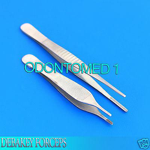

In [8]:
image_path = Path('Surgical_instruments/Sets/Set_S/subsets/Set_1_7/train')

img_files = get_image_files(image_path)

img = PIL.Image.open(img_files[601]) ##
img = img.convert('RGB')

img.to_thumb(150,150)

In [9]:
classes = ['Towel_clip', 'Castroviejo', 'Yankauer', 'Hemostat', 'Army_navy', 'Richardson', 'Potts', 'Iris', 'Bulldog', 'Forceps', 'Scalpel', 'Frazier', 'Needle', 'Weitlaner', 'Mayo_metz']
class_map = ClassMap(classes)
len(class_map)

16

Parse data

In [ ]:
# temporary
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [10]:
!ls Surgical_instruments/Sets/Set_S/subsets/Set_1_7
#!ls gdrive/MyDrive/Surgical_instruments/Set_1_5.v1i.coco

README.md  test  train	valid  whole_set


In [11]:
path = Path('Surgical_instruments/Sets/Set_S/subsets/Set_1_7') # adjust if use git clone vs gdrive
#path = Path('gdrive/MyDrive/Surgical_instruments/Set_1_5.v1i.coco')

train_parser = parsers.COCOBBoxParser(
    annotations_filepath = path/'train/Set_1_7_annotations.coco.json',
    #annotations_filepath = path/'train/Set_1_5_annotations.coco.json',
    #img_dir = path/'train'
    img_dir = path/'train'
)

valid_parser = parsers.COCOBBoxParser(
    annotations_filepath = path/'valid/Set_1_7_annotations.coco.json',
    #annotations_filepath = path/'valid/Set_1_5_annotations.coco.json',
    #img_dir = path/'valid'
    img_dir = path/'valid'
)

In [12]:
# dataset already split in annotation tool, maintain grouping

whole = SingleSplitSplitter()

train_records, *_ = train_parser.parse(data_splitter = whole)

valid_records, *_ = valid_parser.parse(data_splitter = whole)

  0%|          | 0/1323 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/677 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/186 [00:00<?, ?it/s]

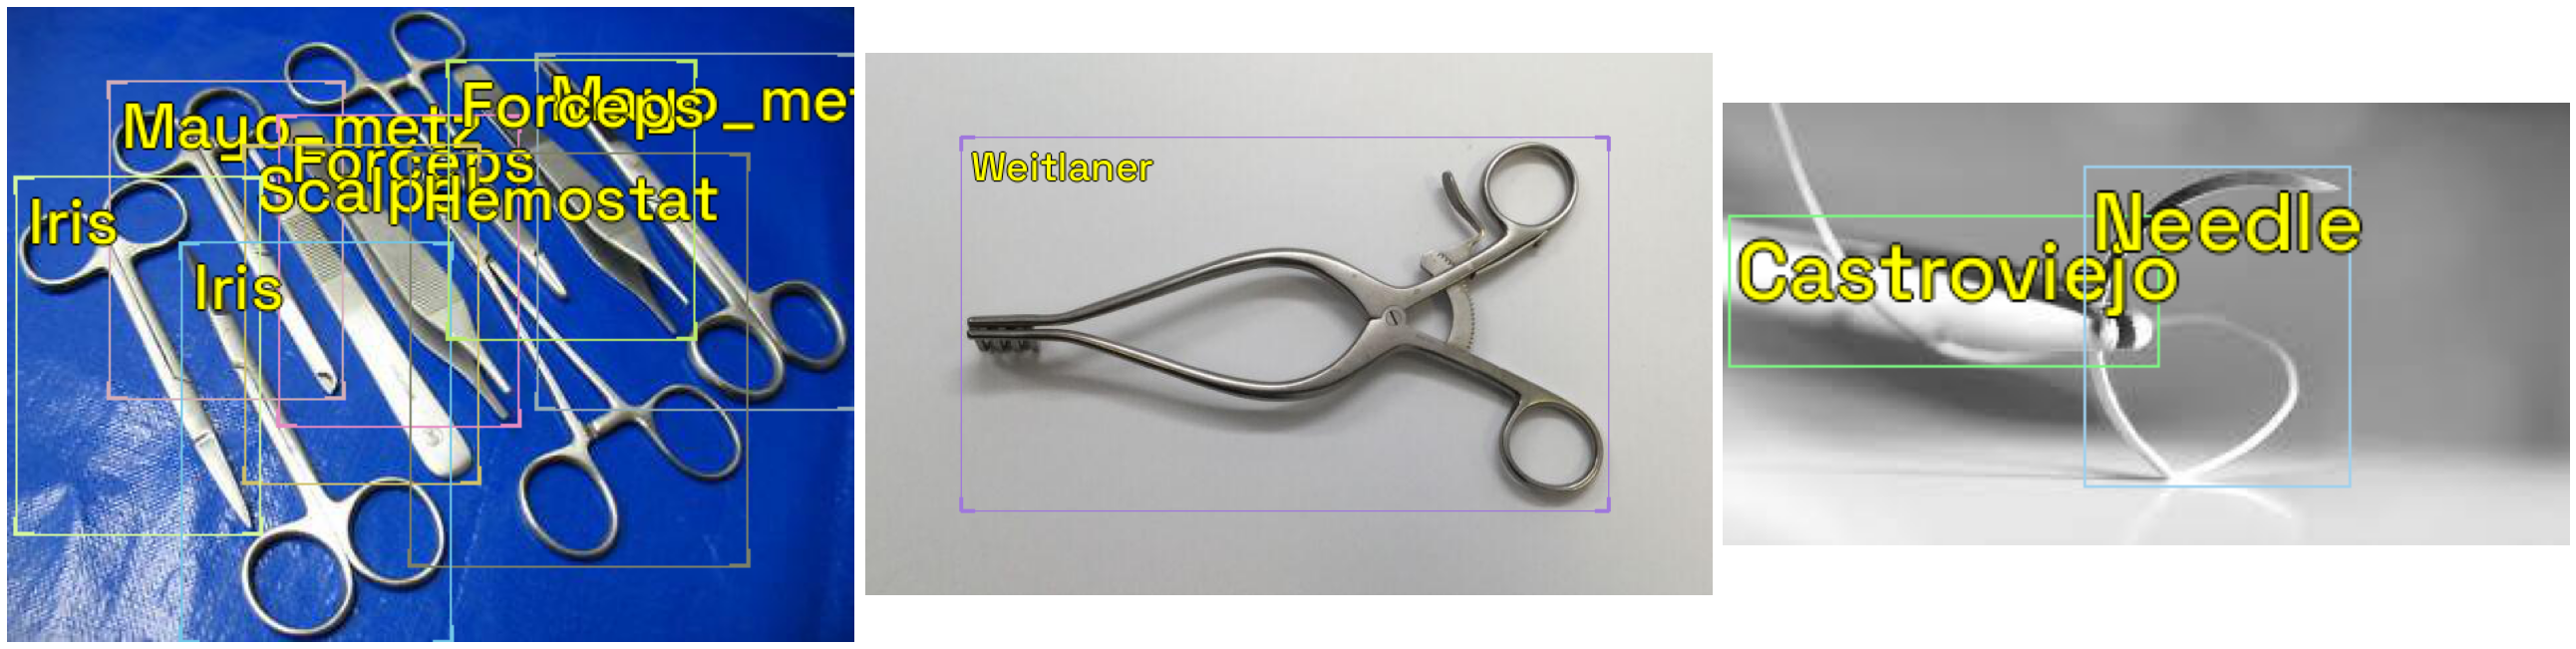

In [13]:
show_records(train_records[0:3],ncols=3, font_size=30, label_color = '#ffff00')

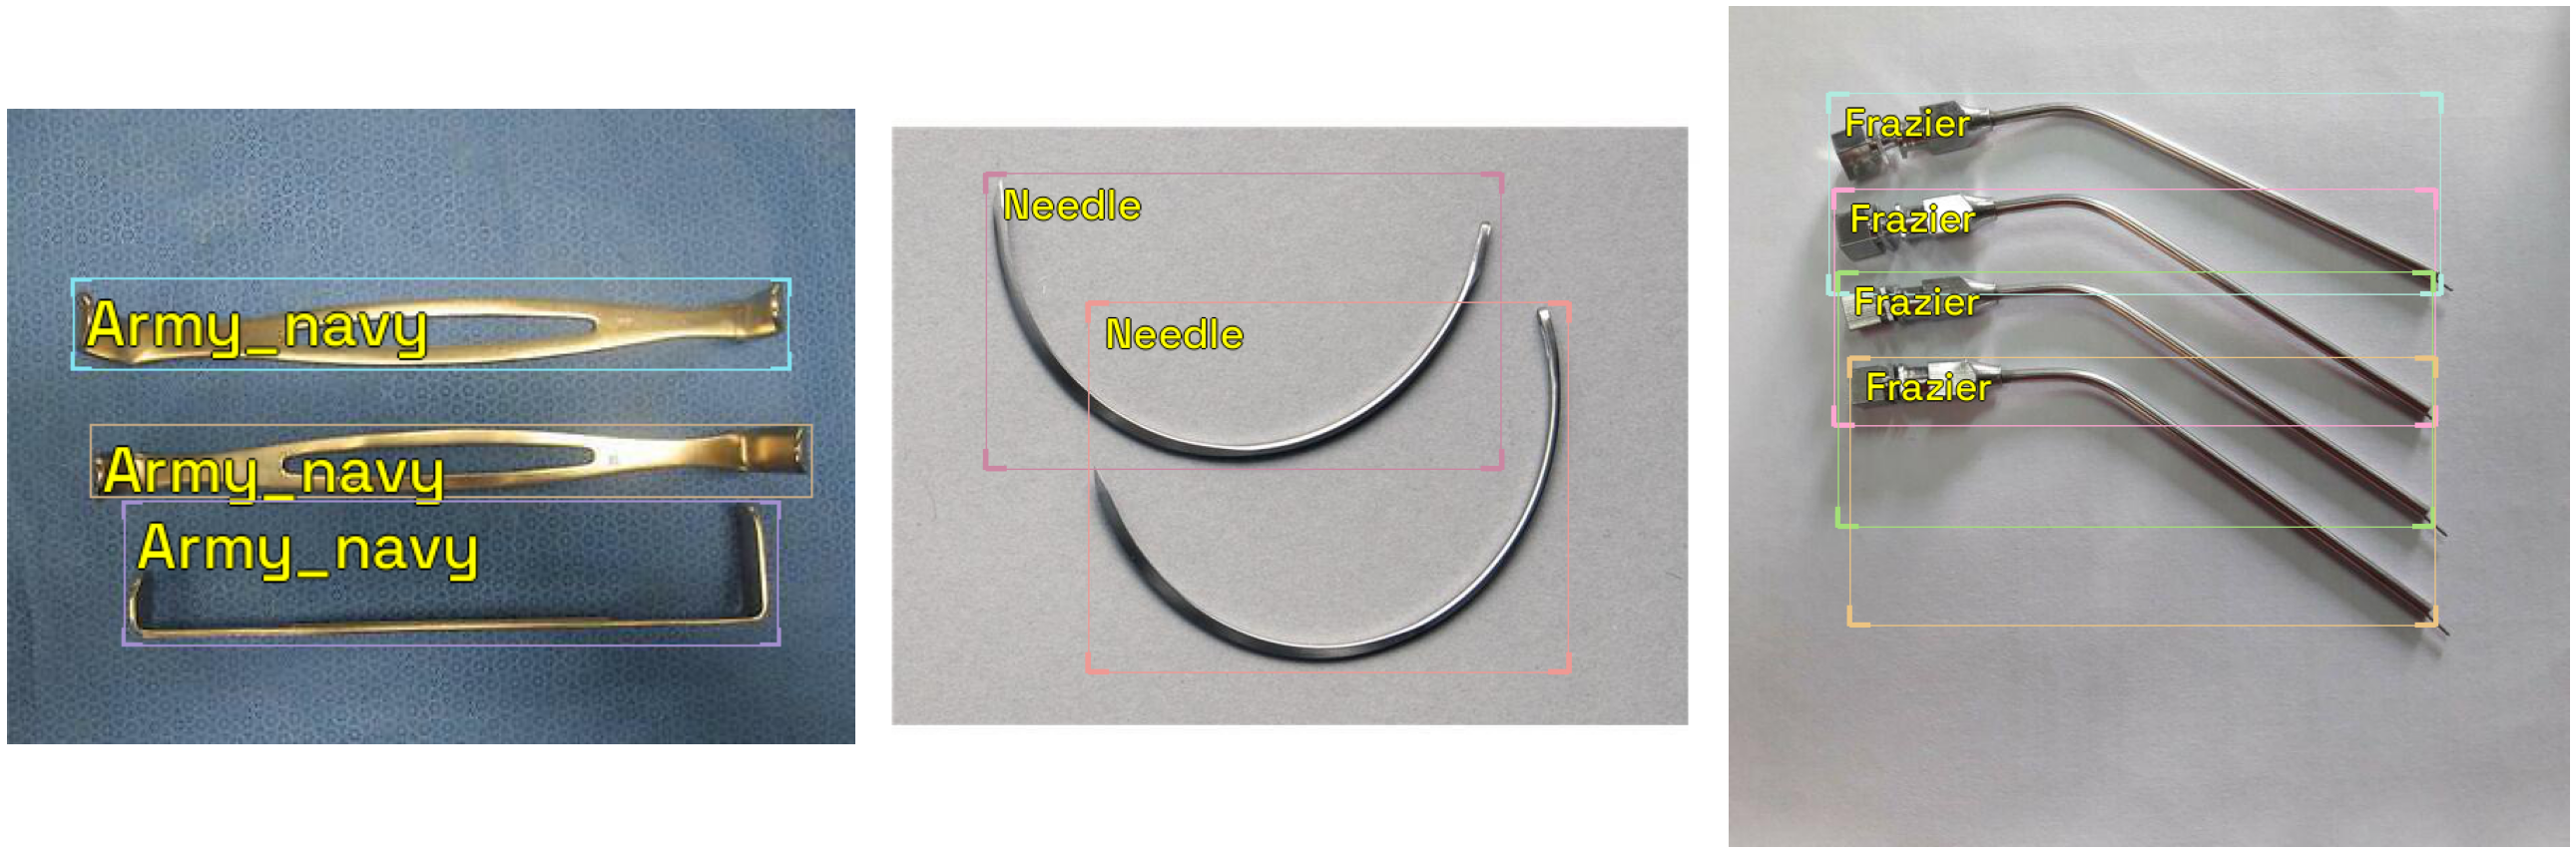

In [14]:
show_records(valid_records[0:3],ncols=3, font_size=30, label_color = '#ffff00')

In [15]:
presize = 512
image_size = 384

train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=image_size), tfms.A.Normalize()])

In [16]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

Train Model_F to generate teacher Model_G using Set_1_7 merged.  

In [17]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

from icevision.models.checkpoint import *

model_type = models.mmdet.retinanet ##
backbone = model_type.backbones.resnet50_fpn_1x##

#model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(classes),)# **extra_args)

In [ ]:
# temporary
#from google.colab import files
#files.upload()

In [ ]:
checkpoint_path = 'Model_F_ret_mAP46.5.pth'

checkpoint_and_model = model_from_checkpoint(checkpoint_path)

model = checkpoint_and_model['model']
model.train()

In [ ]:
train_dl = model_type.train_dl(train_ds, batch_size = 16, num_workers = 4,
                               shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers = 4,
                               shuffle=False)

In [20]:
##
from fastai.callback.wandb import *

wandb.init(project = 'Surgical_instruments', name = 'Model_G_Set_1_7', ##
           reinit = True)

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [21]:
learn = model_type.fastai.learner(dls = [train_dl, valid_dl],
                                  model = model, metrics = metrics,#)
                                  cbs = WandbCallback()) ##

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


SuggestedLRs(valley=0.00015848931798245758)

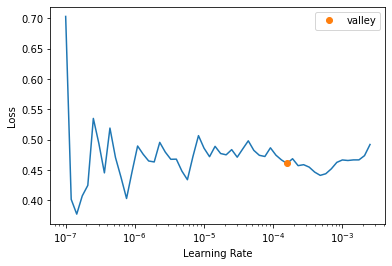

In [22]:
learn.lr_find()

In [24]:
# Set 1_7, retinanet, 
learn.fine_tune(100, 1e-04)

Could not gather input dimensions
WandbCallback requires use of "SaveModelCallback" to log best model
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'Dataset' object has no attribute 'items'


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


Could not gather input dimensions


In [25]:
import matplotlib.pyplot as plt
def plot_metrics(learn, title):
  plt.plot(L(learn.recorder.values).itemgot())
  plt.xlabel('epoch')
  plt.ylabel('mAP (green), Loss (blue, orange)')
  plt.title(title)
  plt.text(0,-0.2, 
       'Legend: mAP(green), train_loss(blue), valid_loss(orange')
  plt.ylim(0,1);

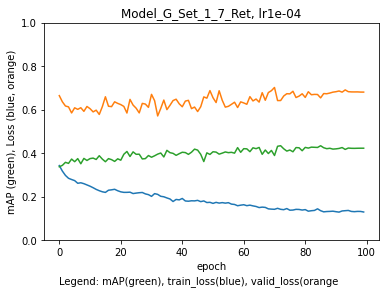

In [26]:
plot_metrics(learn, 'Model_G_Set_1_7_Ret, lr1e-04')

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


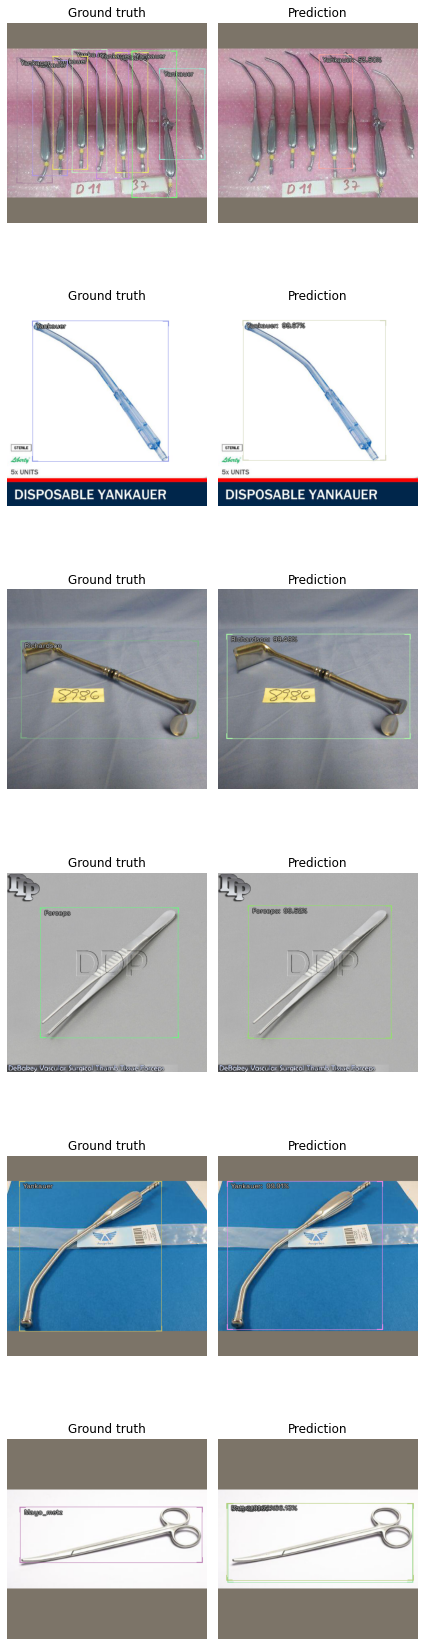

In [27]:
model_type.show_results(model, valid_ds)

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


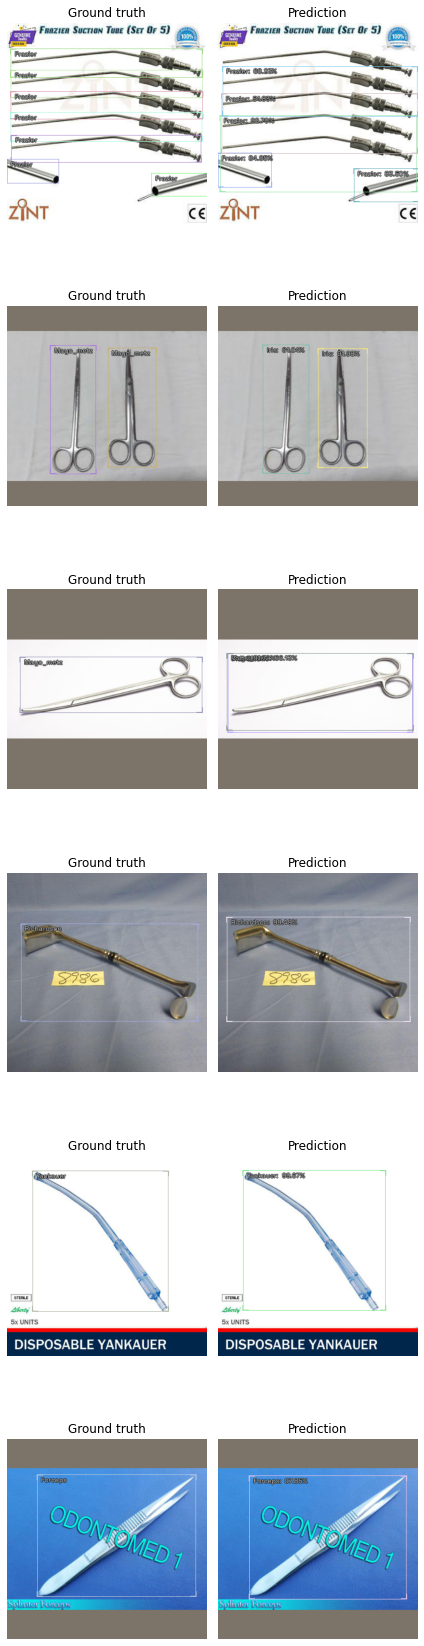

In [28]:
model_type.show_results(model, valid_ds)


In [29]:
from icevision.models import *

checkpoint_path = 'Model_G_ret_mAP42.4.pth'

save_icevision_checkpoint(model, 
                        model_name='mmdet.retinanet', 
                        backbone_name='resnet50_fpn_1x',
                        classes =  train_parser.class_map.get_classes(), 
                        img_size=image_size, 
                        filename=checkpoint_path,
                        meta={'icevision_version': '0.9.1'})

# download model

No inference done for now

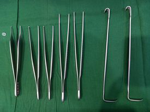

In [ ]:
image_path = Path('Surgical_instruments/Sets/Set_7/raw_images')

img_files = get_image_files(image_path)

img = PIL.Image.open(img_files[0]) ##
img = img.convert('RGB')

img.to_thumb(150,150)

In [ ]:
classes = ['Towel_clip', 'Castroviejo', 'Yankauer', 'Hemostat', 'Army_navy', 'Richardson', 'Potts', 'Iris', 'Bulldog', 'Forceps', 'Scalpel', 'Frazier', 'Needle', 'Weitlaner', 'Mayo_metz']
class_map = ClassMap(classes)

In [ ]:
imgs_array = [PIL.Image.open(file) for file in img_files]

imgs_array = [image.convert('RGB') for image in imgs_array]

img_size = 384 

valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(img_size), tfms.A.Normalize()])

infer_ds = Dataset.from_images(imgs_array, valid_tfms, class_map = class_map)

Use Model F (trained on Set_1_6)

In [ ]:
from icevision.models import *

checkpoint_path = 'Model_F_ret_mAP46.5.pth'

checkpoint_and_model = model_from_checkpoint(checkpoint_path)
model = checkpoint_and_model['model'] # Model F
model.eval()

Inference/ generate pseudolabels for Set_7 using Model F.

In [ ]:
infer_dl = model_type.infer_dl(infer_ds, batch_size=4, shuffle=False)

preds_saved = model_type.predict_from_dl(model, infer_dl,
                                          keep_images=True, 
                                         detection_threshold = 0.5) ##

  0%|          | 0/40 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


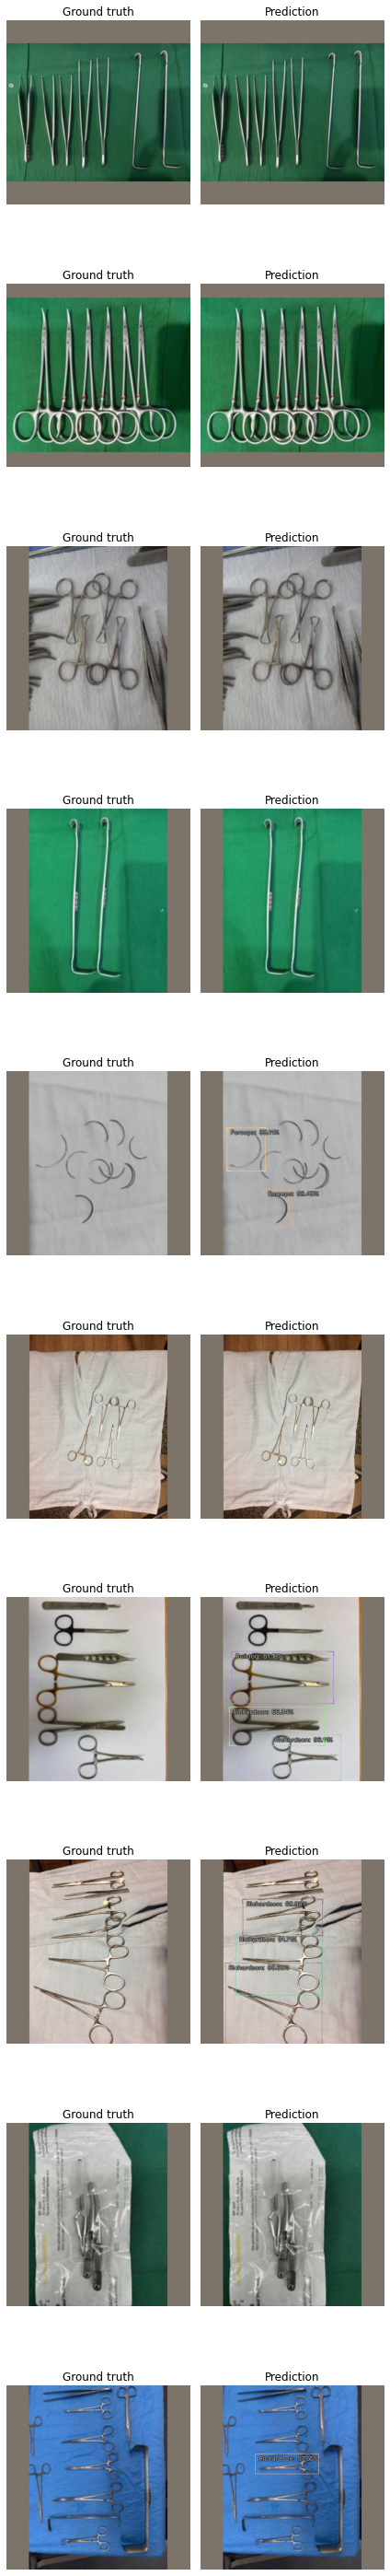

In [ ]:
show_preds(preds = preds_saved[0:10])
# with detection threshold 0.5

Fair pseudolabels: a few fair bboxes, poor classification.

Use for pseudolabels.


In [ ]:

for pred in preds_saved:
  pred.add_component(FilepathRecordComponent())

for _ in range(len(preds_saved)): 
  preds_saved[_].set_filepath(img_files[_]) 

conv = convert_preds_to_coco_style(preds_saved) 

In [ ]:
add_info = {
    "info": {
        "year": "2021",
        "version": "1",
        "description": "Exported from roboflow.ai",
        "contributor": "",
        "url": "https://public.roboflow.ai/object-detection/undefined",
        "date_created": "2021-10-05T20:13:09+00:00"
    },
    "licenses": [
        {
            "id": 1,
            "url": "https://creativecommons.org/licenses/by/4.0/",
            "name": "CC BY 4.0"
        }
    ],
    "categories": [
        {
            "id": 0,
            "name": "instruments",
            "supercategory": "none"
        },
        {
            "id": 1,
            "name": "Army_navy",
            "supercategory": "Retractor"
        },
        {
            "id": 2,
            "name": "Bulldog",
            "supercategory": "Clamp"
        },
        {
            "id": 3,
            "name": "Castroviejo",
            "supercategory": "Needle_holder"
        },
        {
            "id": 4,
            "name": "Forceps",
            "supercategory": "Forceps"
        },
        {
            "id": 5,
            "name": "Frazier",
            "supercategory": "Suction"
        },
        {
            "id": 6,
            "name": "Hemostat",
            "supercategory": "Clamp"
        },
        {
            "id": 7,
            "name": "Iris",
            "supercategory": "Scissors"
        },
       {
            "id": 8,
            "name": "Mayo_metz",
            "supercategory": "Scissors"
        },
        {
            "id": 9,
            "name": "Needle",
            "supercategory": "Needle"
        },
        {
            "id": 10,
            "name": "Potts",
            "supercategory": "Scissors"
        },
        {
            "id": 11,
            "name": "Richardson",
            "supercategory": "Retractor"
        },
        {
            "id": 12,
            "name": "Scalpel",
            "supercategory": "Scalpel"
        },
        {
            "id": 13,
            "name": "Towel_clip",
            "supercategory": "Clamp"
        },
        {
            "id": 14,
            "name": "Weitlaner",
            "supercategory": "Retractor"
        },
        {
            "id": 15,
            "name": "Yankauer",
            "supercategory": "Suction"
        }
    ]
}

In [ ]:
pseudo = {**add_info, **conv}

f = open('pseudo.json','w') 
f.write(str(pseudo)) 
f.close()
##  edit ' to "": annot_.json

Do annotation and split in Roboflow.

Continue iterative training.